In [ ]:
!pip install keras-tuner

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tqdm import tqdm
import datetime
import pickle

2025-04-21 11:35:37.521702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745235337.709691      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745235337.765938      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
ask_file = '/kaggle/input/gbpusd/GBPUSD_15 Mins_Ask_2023.11.17_2025.03.31.csv'
bid_file = '/kaggle/input/gbpusd/GBPUSD_15 Mins_Bid_2023.11.17_2025.03.31.csv'

time_column_name = 'Time (EET)'
time_format = None  # Set to None if the time format is not specified
take_profit_pips = 10   # Take profit in pips
take_profit_level = take_profit_pips / 10000 # Convert pips to price level for GBPUSD (4 decimal places)
forward_window_hours = 4 # How many hours ahead to check for take profit
timeframe_minutes = 15 # Timeframe of the data
sliding_window_size = 50 # Number of past periods (N) to use for prediction
train_test_split_ratio = 0.2 # 10% for testing
validation_split_ratio = 0.2 # 20% of training data for validation
epochs = 25 # Number of epochs for final training SID=2353465=****XYZ, ie epochs = 20+Z
batch_size = 15 # Batch size for final training
patience = 10 # Early stopping patience

# Calculate forward window size in periods
periods_per_hour = 60 // timeframe_minutes
forward_window_periods = forward_window_hours * periods_per_hour

# Set random seed for reproducibility
np.random.seed(19)
tf.random.set_seed(19)

print(f"Ask file: {ask_file}")
print(f"Bid file: {bid_file}")
print(f"Time Column: {time_column_name}")
print(f"Take Profit: {take_profit_pips} pips ({take_profit_level})")
print(f"Forward Window: {forward_window_hours} hours ({forward_window_periods} periods)")
print(f"Sliding Window (N): {sliding_window_size} periods")
print(f"Epochs: {epochs}")
print(f"Batch Size: {batch_size}")
print(f"Patience: {patience}")

  Ask file: /kaggle/input/gbpusd/GBPUSD_15 Mins_Ask_2023.11.17_2025.03.31.csv
  Bid file: /kaggle/input/gbpusd/GBPUSD_15 Mins_Bid_2023.11.17_2025.03.31.csv
  Time Column: Time (EET)
  Take Profit: 10 pips (0.001)
  Forward Window: 4 hours (16 periods)
  Sliding Window (N): 50 periods
  Epochs: 25
  Batch Size: 15
  Patience: 10


# 1. Load and Merge Data

In [ ]:
import os

# Check if both files exist
if not os.path.exists(ask_file) or not os.path.exists(bid_file):
    print("Error: One or both CSV files not found")
    exit()
else:
    # Load data
    df_ask = pd.read_csv(ask_file, parse_dates=[time_column_name], date_format=time_format)
    df_bid = pd.read_csv(bid_file, parse_dates=[time_column_name], date_format=time_format)

    # Handle potential space or non-ASCII characters in column names
    df_ask.columns = df_ask.columns.str.strip().str.replace('\u00A0', '', regex=False)
    df_bid.columns = df_bid.columns.str.strip().str.replace('\u00A0', '', regex=False)

    # Rename columns to include cleaning:
    df_ask.rename(columns={
        'Open': 'Open_Ask',
        'High': 'High_Ask',
        'Low': 'Low_Ask',
        'Close': 'Close_Ask',
        'Volume': 'Volume_Ask'
    }, inplace=True)

    df_bid.rename(columns={
        'Open': 'Open_Bid',
        'High': 'High_Bid',
        'Low': 'Low_Bid',
        'Close': 'Close_Bid',
        'Volume': 'Volume_Bid'
    }, inplace=True)

    print("Ask Data Head:")
    print(df_ask.head(3))
    print("\nBid Data Head:")
    print(df_bid.head(3))

    # Check if time_column_name exists in both DataFrames before merging
    if time_column_name not in df_ask.columns or time_column_name not in df_bid.columns:
        print(f"Error: '{time_column_name}' column not found in one of the files")
        exit()
    
    # Merge df_ask and df_bid into a single DataFrame called 'data'
    data = pd.merge(df_ask, df_bid, on=time_column_name)

    print("Merged Data Head:")
    print(data.head(3))


Ask Data Head:
           Time (EET)  Open_Ask  High_Ask  Low_Ask  Close_Ask  Volume_Ask
0 2023-11-17 00:00:00   1.24184   1.24229  1.24165    1.24165      167.11
1 2023-11-17 00:15:00   1.24175   1.24195  1.24126    1.24139      241.20
2 2023-11-17 00:30:00   1.24143   1.24165  1.24139    1.24149      390.15

Bid Data Head:
           Time (EET)  Open_Bid  High_Bid  Low_Bid  Close_Bid  Volume_Bid
0 2023-11-17 00:00:00   1.24115   1.24167  1.24075    1.24150      210.74
1 2023-11-17 00:15:00   1.24150   1.24150  1.24095    1.24121      682.60
2 2023-11-17 00:30:00   1.24122   1.24141  1.24106    1.24114     1430.04
Merged Data Head:
           Time (EET)  Open_Ask  High_Ask  Low_Ask  Close_Ask  Volume_Ask  \
0 2023-11-17 00:00:00   1.24184   1.24229  1.24165    1.24165      167.11   
1 2023-11-17 00:15:00   1.24175   1.24195  1.24126    1.24139      241.20   
2 2023-11-17 00:30:00   1.24143   1.24165  1.24139    1.24149      390.15   

   Open_Bid  High_Bid  Low_Bid  Close_Bid  Volume_

# 2. Feature Engineering

In [ ]:
# Convert time to UTC and set as index
# Convert to datetime with coercion (invalid parsing will result in NaT)
data[time_column_name] = pd.to_datetime(data[time_column_name], errors='coerce')

# Drop rows where datetime conversion failed
if data[time_column_name].isnull().any():
    print("An error occurred during time processing: Invalid datetime found.")
    exit()
else:
    # Rename for consistency
    data.rename(columns={time_column_name: 'Local_Time'}, inplace=True)

    # Check if all entries are timezone-unaware before localizing
    if data['Local_Time'].dt.tz is None:
        try:
            data['Timestamp_UTC'] = data['Local_Time'].dt.tz_localize('Europe/Helsinki', ambiguous='infer').dt.tz_convert('UTC')
        except Exception as e:
            print(f"An error occurred during time localization/conversion: {e}")
            exit()
        
        print("Localized time from EET and converted to UTC.")

        data.set_index('Timestamp_UTC', inplace=True)
        data.sort_index(inplace=True)
        data.drop(['Local_Time'], axis=1, inplace=True)
    else:
        print("An error occurred: Local_Time already has timezone info.")
        exit()



# Calculate Price Deltas
data["Open_Delta"] = data["Open_Ask"] - data["Open_Bid"]
data["High_Delta"] = data["High_Ask"] - data["High_Bid"]
data["Low_Delta"] = data["Low_Ask"] - data["Low_Bid"]
data["Close_Delta"] = data["Close_Ask"] - data["Close_Bid"]

# Calculate Volume Deltas
data["Volume_Delta"] = data["Volume_Ask"] - data["Volume_Bid"]
data["Volume_Delta_abs"] = data["Volume_Delta"].abs()

# Identify Time Gaps
data['Time_Diff'] = data.index.to_series().diff()

# Handle the first entry's NaT at column Time_Diff
if not data.empty:
    data['Time_Diff'].fillna(pd.Timedelta(seconds=0), inplace=True) # Fill first NaN

# Define expected interval
expected_interval = pd.Timedelta(minutes=timeframe_minutes)
# Allow for small variations
tolerance = pd.Timedelta(seconds=60)

# Convert 'Time_Diff' to numeric (seconds) before comparison**
data['Time_Diff_Seconds'] = data['Time_Diff'].dt.total_seconds()

# Mark gaps larger than the expected interval + tolerance
data['Gap_Indicator'] = data['Time_Diff_Seconds'] > (expected_interval + tolerance).total_seconds()

# Create 'New_Day' and 'New_Week' columns
data['New_Day'] = data['Gap_Indicator'].astype(int)
data['New_Week'] = (data['Time_Diff'] > pd.Timedelta(days=1)).astype(int)

# Add columns for rolling Min/Max needed for target variable
data['Y_Low_Ask'] = data['Low_Ask']
data['Y_High_Bid'] = data['High_Bid']

# Drop intermediate columns
data = data.drop(['Time_Diff', 'Gap_Indicator'], axis=1)

print(data.head())

Localized time from EET and converted to UTC.
                           Open_Ask  High_Ask  Low_Ask  Close_Ask  Volume_Ask  \
Timestamp_UTC                                                                   
2023-11-16 22:00:00+00:00   1.24184   1.24229  1.24165    1.24165      167.11   
2023-11-16 22:15:00+00:00   1.24175   1.24195  1.24126    1.24139      241.20   
2023-11-16 22:30:00+00:00   1.24143   1.24165  1.24139    1.24149      390.15   
2023-11-16 22:45:00+00:00   1.24151   1.24194  1.24148    1.24182      637.20   
2023-11-16 23:00:00+00:00   1.24183   1.24184  1.24146    1.24163      306.91   

                           Open_Bid  High_Bid  Low_Bid  Close_Bid  Volume_Bid  \
Timestamp_UTC                                                                   
2023-11-16 22:00:00+00:00   1.24115   1.24167  1.24075    1.24150      210.74   
2023-11-16 22:15:00+00:00   1.24150   1.24150  1.24095    1.24121      682.60   
2023-11-16 22:30:00+00:00   1.24122   1.24141  1.24106    1.24

/tmp/ipykernel_31/3697889285.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Time_Diff'].fillna(pd.Timedelta(seconds=0), inplace=True) # Fill first NaN


# 3. Target Variable Creation

In [6]:
# Calculate future min/max using a forward rolling window
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=forward_window_periods)
data['Y_Low_Ask_Future'] = data['Y_Low_Ask'].rolling(window=indexer, min_periods=1).min()
data['Y_High_Bid_Future'] = data['Y_High_Bid'].rolling(window=indexer, min_periods=1).max()


# Define the 'Trend_Flat' target variable
buy_tp_hit = (data["Y_High_Bid_Future"] - data["Close_Ask"]) >= take_profit_level
sell_tp_hit = (data["Close_Bid"] - data["Y_Low_Ask_Future"]) >= take_profit_level

data['Trend_Flat'] = ((buy_tp_hit) | (sell_tp_hit)).astype(int)

# Remove rows with NaN in future values (the last 'forward_window_periods' rows)
print(f"Original data length: {len(data)}")
data.dropna(subset=['Y_Low_Ask_Future', 'Y_High_Bid_Future'], inplace=True)
# print(f"Data length after removing rows for future lookup: {len(data)}")

# Drop temporary columns
data = data.drop(['Y_Low_Ask', 'Y_High_Bid', 'Y_Low_Ask_Future', 'Y_High_Bid_Future'], axis=1)

print("'Trend_Flat' target variable created.")
print("Class distribution:")
print(data['Trend_Flat'].value_counts(normalize=True))

Original data length: 33964
'Trend_Flat' target variable created.
Class distribution:
Trend_Flat
1    0.781386
0    0.218614
Name: proportion, dtype: float64


# 4. Data Normalization

In [7]:
# Separate features (X) and target (y)
target_column = 'Trend_Flat'
y = data[target_column]
X = data.drop(target_column, axis=1)

# Get feature names before scaling
feature_names = X.columns.tolist()

# Use MinMaxScaler for all features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names, index=X.index)

print(X_scaled_df.head())

                           Open_Ask  High_Ask   Low_Ask  Close_Ask  \
Timestamp_UTC                                                        
2023-11-16 22:00:00+00:00  0.238045  0.232997  0.239063   0.236612   
2023-11-16 22:15:00+00:00  0.237366  0.230419  0.236116   0.234651   
2023-11-16 22:30:00+00:00  0.234952  0.228145  0.237099   0.235405   
2023-11-16 22:45:00+00:00  0.235556  0.230343  0.237779   0.237894   
2023-11-16 23:00:00+00:00  0.237970  0.229585  0.237628   0.236461   

                           Volume_Ask  Open_Bid  High_Bid   Low_Bid  \
Timestamp_UTC                                                         
2023-11-16 22:00:00+00:00    0.005647  0.233391  0.228833  0.232908   
2023-11-16 22:15:00+00:00    0.008151  0.236030  0.227545  0.234419   
2023-11-16 22:30:00+00:00    0.013185  0.233919  0.226863  0.235250   
2023-11-16 22:45:00+00:00    0.021534  0.233391  0.228151  0.235703   
2023-11-16 23:00:00+00:00    0.010372  0.235653  0.227621  0.236232   

           

# 5. Data Preparation for LSTM

In [8]:
# Convert scaled features and target to numpy arrays
X_np = X_scaled_df.to_numpy()
y_np = y.to_numpy().reshape(-1, 1) # Reshape y to be (n_samples, 1)

# Create 3D sequences [samples, timesteps, features]
num_samples = X_np.shape[0]
num_features = X_np.shape[1]
num_sequences = num_samples - sliding_window_size + 1

# Initialize empty arrays for sequences
X_sequences = np.zeros((num_sequences, sliding_window_size, num_features), dtype=np.float32)
y_sequences = np.zeros((num_sequences, 1), dtype=np.float32)

# Populate the sequence arrays
for i in tqdm(range(num_sequences)):
    X_sequences[i] = X_np[i : i + sliding_window_size]
    # Target corresponds to the end of the sequence window
    y_sequences[i] = y_np[i + sliding_window_size - 1]

print("X_sequences shape:", X_sequences.shape)
print("y_sequences shape:", y_sequences.shape)

100%|██████████| 33915/33915 [00:00<00:00, 186469.35it/s]

X_sequences shape: (33915, 50, 19)
y_sequences shape: (33915, 1)


# 6. Train/Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=train_test_split_ratio, shuffle=False, stratify=None
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (27132, 50, 19)
y_train shape: (27132, 1)
X_test shape: (6783, 50, 19)
y_test shape: (6783, 1)


# 7. Handle Class Imbalance

In [ ]:
# Compute class weights on the training data
y_train_flat = y_train.ravel() # Flatten for compute_class_weight
unique_classes = np.unique(y_train_flat)

if len(unique_classes) > 1:
    class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_flat)    # Compute class weights
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}    # Convert to dictionary format
    print("Calculated class weights:")
    print(class_weight_dict)
else:
    print("Warning: Only one class present in the training data. Class weights not applied.")
    class_weight_dict = None    # No class weights to apply


Calculated class weights:
{0: 2.1052141527001864, 1: 0.6557424593967517}


# 8. Model Building

In [ ]:
model = Sequential([
    LSTM(units=33, return_sequences=True, input_shape=(sliding_window_size, num_features)), # 1st layer
    Dropout(0.4),   # Dropout layer
    LSTM(units=66, return_sequences=True, input_shape=(sliding_window_size, num_features)), # 2nd layer
    Dropout(0.4),   # Dropout layer
    LSTM(units=99, return_sequences=True, input_shape=(sliding_window_size, num_features)), # 3rd layer
    Dropout(0.4),       # Dropout layer
    LSTM(units=30), # 3rd layer
    Dense(1, activation='sigmoid') # Output layer for binary classification 
])

# Compile the model
model.compile(optimizer=AdamW(), loss='binary_crossentropy', metrics=['accuracy'])  # 9. Training the Model

model.summary()

I0000 00:00:1745235350.115982      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 33)              │           6,996 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 33)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50, 66)              │          26,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 66)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50, 99)              │          65,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50, 99)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 30)                  │          15,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 114,763 (448.29 KB)

 Trainable params: 114,763 (448.29 KB)

 Non-trainable params: 0 (0.00 B)

# 9. Training the Model

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_GBPUSD_TrendFlat_model.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(
    X_train, y_train,    # Training data
    epochs=epochs,        # Number of epochs
    batch_size=batch_size,  # Batch size
    validation_split=validation_split_ratio, # Use validation split on training data
    shuffle=True, # Shuffle training data each epoch
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weight_dict, # Apply class weights
    verbose=1
)

# Save history
if history and hasattr(history, 'history'):
    if isinstance(history.history, dict):
        with open('gbpusd_training_history.pkl', 'wb') as file:
            pickle.dump(history.history, file)
        print("Training history saved to gbpusd_training_history.pkl")
    else:
        print("Could not save training history. Error: 'history' attribute is not a dictionary.")
else:
    print("Could not save training history. Error: Invalid 'history' object.")

Epoch 1/25


I0000 00:00:1745235357.122450      93 cuda_dnn.cc:529] Loaded cuDNN version 90300


1445/1447 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4303 - loss: 0.7095
Epoch 1: val_loss improved from inf to 0.67274, saving model to best_GBPUSD_TrendFlat_model.keras
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.4303 - loss: 0.7094 - val_accuracy: 0.4889 - val_loss: 0.6727
Epoch 2/25
1446/1447 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6899 - loss: 0.5873
Epoch 2: val_loss improved from 0.67274 to 0.55596, saving model to best_GBPUSD_TrendFlat_model.keras
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.6900 - loss: 0.5872 - val_accuracy: 0.6641 - val_loss: 0.5560
Epoch 3/25
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7422 - loss: 0.5173
Epoch 3: val_loss improved from 0.55596 to 0.54227, saving model to best_GBPUSD_TrendFlat_model.keras
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.7422 - loss: 0.5173 - val_accuracy: 0.6540 - val_loss: 0.5423
Epoch 4/25
1444/1447 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7464 - los

# 10. Evaluation of the Model

In [ ]:
# Load the best model saved by ModelCheckpoint# Load best model
if os.path.exists('best_GBPUSD_TrendFlat_model.keras'):
    best_model = keras.models.load_model('best_GBPUSD_TrendFlat_model.keras')
    print("Loaded best model from checkpoint.")
else:
    print("Could not load best model from checkpoint. File does not exist.")
    best_model = model  # Fallback to the model in memory

# Evaluate on the test set
scores = best_model.evaluate(X_test, y_test, verbose=1)
print("\nTest Set Evaluation:")
print(f"Loss: {scores[0]:.4f}")
print(f"Accuracy: {scores[1]*100:.2f}%")

# Generate classification report
predictions_prob = best_model.predict(X_test)
predictions_binary = np.round(predictions_prob)

print("\nClassification Report (Test Set):")
# Ensure y_test is flattened if needed for classification_report
y_test_flat = y_test.ravel()
if len(np.unique(y_test_flat)) > 1:
     report = classification_report(y_test_flat, predictions_binary, digits=4)
     print(report)
else:
     print("Cannot generate full report.")

Loaded best model from checkpoint.
212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7872 - loss: 0.3925

Test Set Evaluation:
Loss: 0.3981
Accuracy: 78.56%
212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0     0.3652    0.6825    0.4758       967
         1.0     0.9383    0.8028    0.8653      5816

    accuracy                         0.7856      6783
   macro avg     0.6518    0.7427    0.6706      6783
weighted avg     0.8566    0.7856    0.8098      6783



# 11. Visualization of the results

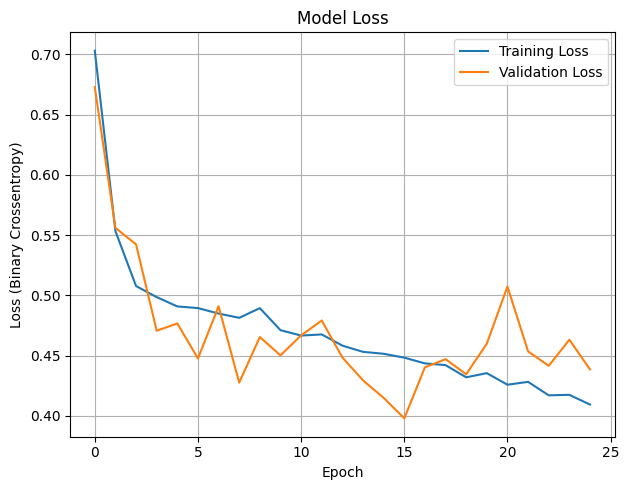

In [14]:
# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Binary Crossentropy)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

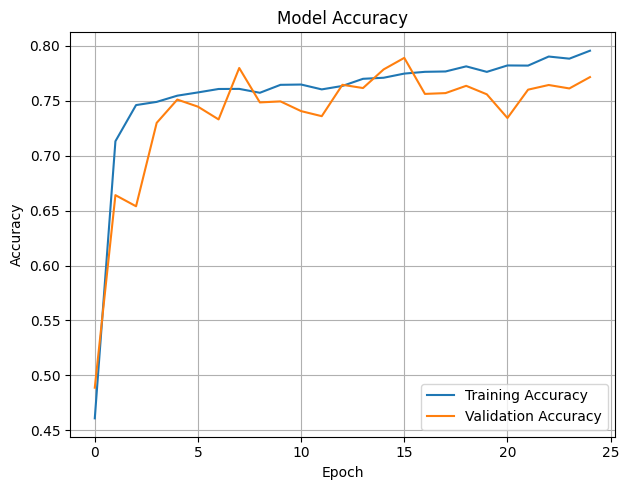

In [15]:
# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 12. Hyperparameter Tuning

In [ ]:
# Ensure necessary libraries are imported
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
import numpy as np
import pickle

# Model Building Function for Tuner

def build_lstm_model_tuned(hp): # Hyperparameters
    model = keras.Sequential()
    model.add(LSTM(units=hp.Int('lstm_units_1', min_value=20, max_value=100, step=20),  # Tune the number of units
                   return_sequences=True,   # Return sequences for next LSTM layer
                   input_shape=(sliding_window_size, num_features)))    # Input shape

    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))    # Tune dropout rate

    model.add(LSTM(units=hp.Int('lstm_units_2', min_value=10, max_value=50, step=10)))  # 2nd LSTM layer

    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))    # Tune dropout rate

    model.add(Dense(1, activation='sigmoid')) # Output layer

    # Tune the learning rate for AdamW optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])    # Tune learning rate

    model.compile(optimizer=AdamW(learning_rate=learning_rate), # Compile the model
                  loss='binary_crossentropy',   # Binary crossentropy loss
                  metrics=['accuracy']) # Accuracy metric
    return model

# Use RandomSearch
tuner_lstm = kt.RandomSearch(
    build_lstm_model_tuned,
    objective='val_accuracy', # Optimize for validation accuracy
    max_trials=7,             # Number of hyperparameter combinations
    executions_per_trial=2,
    directory='lstm_tuning_dir', # Directory to store results
    project_name='gbpusd_lstm_tuning'
)

# Define callbacks for tuning search
tuning_early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1)

tuner_lstm.search_space_summary() # Tuner Search Summary

tuner_lstm.search(X_train, y_train,
                  epochs=10,
                  validation_split=validation_split_ratio,
                  shuffle=True,
                  callbacks=[tuning_early_stopping],
                  class_weight=class_weight_dict # Apply class weights
                 )

# Summarize Best Results
# Get the optimal hyperparameters
best_hps_lstm = tuner_lstm.get_best_hyperparameters(num_trials=1)[0]

# Get the best model
best_lstm_model_tuned = tuner_lstm.get_best_models(num_models=1)[0]
print("\nBest Tuned LSTM Model Summary:")
best_lstm_model_tuned.summary()

# Save Tuner Results
if tuner_lstm and hasattr(tuner_lstm, 'oracle') and hasattr(tuner_lstm.oracle, 'trials'):
    trial_details_lstm = {}
    for trial_id, trial in tuner_lstm.oracle.trials.items():
        trial_details_lstm[trial_id] = {
            'hyperparameters': trial.hyperparameters.values,
            'score': trial.score,
            'metrics': trial.metrics.metrics
        }
    
    if trial_details_lstm:  # Proceed only if there are trials collected
        with open('lstm_tuner_trial_details.pkl', 'wb') as f:
            pickle.dump(trial_details_lstm, f)
        print("LSTM tuner trial details saved to lstm_tuner_trial_details.pkl")
    else:
        print("Could not save tuner details. No trials found.")
else:
    print("Could not save tuner details. Tuner object is invalid or has no trials.")


# Evaluate the best tuned modelCould 
print("\nEvaluating Best Tuned LSTM Model on Test Set:")
tuned_lstm_scores = best_lstm_model_tuned.evaluate(X_test, y_test, verbose=1)
print(f"Loss: {tuned_lstm_scores[0]:.4f}")
print(f"Accuracy: {tuned_lstm_scores[1]*100:.2f}%")

# Generate classification report
tuned_lstm_predictions_prob = best_lstm_model_tuned.predict(X_test)
tuned_lstm_predictions_binary = np.round(tuned_lstm_predictions_prob)

y_test_flat = y_test.ravel()
if len(np.unique(y_test_flat)) > 1:
     report_tuned_lstm = classification_report(y_test_flat, tuned_lstm_predictions_binary, digits=4)
     print(report_tuned_lstm)
else:
     print("Cannot generate full report.")

Trial 7 Complete [00h 01m 57s]
val_accuracy: 0.7622074782848358

Best val_accuracy So Far: 0.8207112848758698
Total elapsed time: 00h 13m 37s

Best Tuned LSTM Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 80)              │          32,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 80)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30)                  │          13,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,351 (177.15 KB)

 Trainable params: 45,351 (177.15 KB)

 Non-trainable params: 0 (0.00 B)

LSTM tuner trial details saved to lstm_tuner_trial_details.pkl

Evaluating Best Tuned LSTM Model on Test Set:
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8345 - loss: 0.5961
Loss: 0.6009
Accuracy: 84.03%
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

         0.0     0.3897    0.2120    0.2746       967
         1.0     0.8782    0.9448    0.9103      5816

    accuracy                         0.8403      6783
   macro avg     0.6340    0.5784    0.5925      6783
weighted avg     0.8086    0.8403    0.8197      6783



# 2. Hybrid model (LSTM+GRU) with hyperparameter tuning

In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

from tensorflow.keras.layers import LSTM, GRU
import keras_tuner as kt

# Configuration
ask_file = '/kaggle/input/gbpusd/GBPUSD_15 Mins_Ask_2023.11.17_2025.03.31.csv'
bid_file = '/kaggle/input/gbpusd/GBPUSD_15 Mins_Bid_2023.11.17_2025.03.31.csv'
time_column_fallback = 'Time (EET)'
time_format = None
take_profit_pips = 10
take_profit_level = take_profit_pips / 10000
forward_window_hours = 4
timeframe_minutes = 15
sliding_window_size = 50
train_test_split_ratio = 0.1
validation_split_ratio = 0.2
epochs = 25
batch_size = 15
patience = 10

periods_per_hour = 60 // timeframe_minutes
forward_window_periods = forward_window_hours * periods_per_hour

np.random.seed(19)
tf.random.set_seed(19)

# 1. Load and Inspect Data

In [ ]:
# Check if both files exist
if not os.path.exists(ask_file) or not os.path.exists(bid_file):
    print("CSV files not found.")
    exit()
else:
    # Use correct delimiter (comma), not tab
    df_ask = pd.read_csv(ask_file, sep=',')
    df_bid = pd.read_csv(bid_file, sep=',')

    print("ASK CSV Columns:", df_ask.columns.tolist())
    print("BID CSV Columns:", df_bid.columns.tolist())

    # Clean column names
    df_ask.columns = df_ask.columns.str.strip().str.replace('\u00A0', '', regex=False)
    df_bid.columns = df_bid.columns.str.strip().str.replace('\u00A0', '', regex=False)

    # Check if time column exists
    if time_column_fallback not in df_ask.columns or time_column_fallback not in df_bid.columns:
        print(f"Error: '{time_column_fallback}' not found in one of the CSV files.")
        exit()

    # Parse datetime
    data_ask_time_parsed = pd.to_datetime(df_ask[time_column_fallback], format=time_format, errors='coerce')
    data_bid_time_parsed = pd.to_datetime(df_bid[time_column_fallback], format=time_format, errors='coerce')

    if data_ask_time_parsed.isnull().any() or data_bid_time_parsed.isnull().any():
        print(f"Error: Some datetime parsing failed using format '{time_format}'.")
        exit()
    else:
        df_ask[time_column_fallback] = data_ask_time_parsed
        df_bid[time_column_fallback] = data_bid_time_parsed

    # Merge on time column
    data = pd.merge(df_bid, df_ask, on=time_column_fallback, how='inner', suffixes=('_Bid', '_Ask'))

    # Rename for consistency
    data.rename(columns={time_column_fallback: 'Local_Time'}, inplace=True)
    print(f"\nLoaded and merged data shape: {data.shape}")


ASK CSV Columns: ['Time (EET)', 'Open', 'High', 'Low', 'Close', 'Volume ']
BID CSV Columns: ['Time (EET)', 'Open', 'High', 'Low', 'Close', 'Volume ']

Loaded and merged data shape: (33964, 11)


# 2. Feature Engineering and Data Preprocessing

In [ ]:
# Check if 'Local_Time' column is in datetime format
if not pd.api.types.is_datetime64_any_dtype(data['Local_Time']):
    data['Local_Time'] = pd.to_datetime(data['Local_Time'], errors='coerce')

# Drop rows where 'Local_Time' couldn't be parsed
data.dropna(subset=['Local_Time'], inplace=True)

# Check if 'Local_Time' is timezone-naive
if data['Local_Time'].dt.tz is None:
    localized = False
    try_localized = pd.Series(dtype='datetime64[ns, UTC]')
    try:
        try_localized = data['Local_Time'].dt.tz_localize('Europe').dt.tz_convert('UTC')
        localized = True
    except Exception:
        localized = False

    if localized:
        data['Timestamp_UTC'] = try_localized
    else:
        data['Timestamp_UTC'] = data['Local_Time']
else:
    data['Timestamp_UTC'] = data['Local_Time'].dt.tz_convert('UTC')

# Set Timestamp_UTC as index
data.set_index('Timestamp_UTC', inplace=True)
data.sort_index(inplace=True)
data.drop(['Local_Time'], axis=1, inplace=True)

# Feature Engineering
columns_needed = ['Open_Ask', 'Open_Bid', 'High_Ask', 'High_Bid', 'Low_Ask', 'Low_Bid', 'Close_Ask', 'Close_Bid', 'Volume_Ask', 'Volume_Bid']

if all(col in data.columns for col in columns_needed):
    data["Open_Delta"] = data["Open_Ask"] - data["Open_Bid"]
    data["High_Delta"] = data["High_Ask"] - data["High_Bid"]
    data["Low_Delta"] = data["Low_Ask"] - data["Low_Bid"]
    data["Close_Delta"] = data["Close_Ask"] - data["Close_Bid"]
    data["Volume_Delta"] = data["Volume_Ask"] - data["Volume_Bid"]
    data["Volume_Delta_abs"] = data["Volume_Delta"].abs()
else:
    print("Error: Some required columns for delta calculation are missing.")
    exit()

# Time Difference Feature
data['Time_Diff'] = data.index.to_series().diff().fillna(pd.Timedelta(seconds=0))

# Gap Indicator
expected_interval = pd.Timedelta(minutes=timeframe_minutes)
tolerance = pd.Timedelta(seconds=60)
data['Gap_Indicator'] = data['Time_Diff'] > (expected_interval + tolerance)

# New Day and Week Features
data['New_Day'] = data['Gap_Indicator'].astype(int)
data['New_Week'] = (data['Time_Diff'] > pd.Timedelta(days=1)).astype(int)

# Add Y_Low_Ask and Y_High_Bid
if 'Low_Ask' in data.columns and 'High_Bid' in data.columns:
    data['Y_Low_Ask'] = data['Low_Ask']
    data['Y_High_Bid'] = data['High_Bid']
else:
    print("Error: 'Low_Ask' or 'High_Bid' columns missing for Y_Low_Ask/Y_High_Bid features.")
    exit()

# Drop intermediate columns
data = data.drop(['Time_Diff', 'Gap_Indicator'], axis=1)

print("Feature engineering complete.")


Feature engineering complete.


# 3. Target Variable Creation Create variables to hold the target values for analysis.

In [ ]:
# Check for necessary columns before proceeding
required_columns = ['Y_Low_Ask', 'Y_High_Bid', 'Close_Ask', 'Close_Bid']
if not all(col in data.columns for col in required_columns):
    print(f"Error: One or more required columns are missing: {required_columns}")
    exit()

# Check for necessary window size variable
if not isinstance(forward_window_periods, int) or forward_window_periods <= 0:
    print(f"Error: Invalid 'forward_window_periods' value: {forward_window_periods}")
    exit()

# Apply the rolling window operation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=forward_window_periods)

data['Y_Low_Ask_Future'] = data['Y_Low_Ask'].rolling(window=indexer, min_periods=1).min()
data['Y_High_Bid_Future'] = data['Y_High_Bid'].rolling(window=indexer, min_periods=1).max()

# Calculate Take Profit conditions
buy_tp_hit = (data["Y_High_Bid_Future"] - data["Close_Ask"]) >= take_profit_level
sell_tp_hit = (data["Close_Bid"] - data["Y_Low_Ask_Future"]) >= take_profit_level

# Create 'Trend_Flat' column based on take profit hits
data['Trend_Flat'] = ((buy_tp_hit) | (sell_tp_hit)).astype(int)

# Drop intermediate columns and rows with missing values
data.dropna(subset=['Y_Low_Ask_Future', 'Y_High_Bid_Future'], inplace=True)
data.drop(['Y_Low_Ask', 'Y_High_Bid', 'Y_Low_Ask_Future', 'Y_High_Bid_Future'], axis=1, inplace=True)

# Print results
print("'Trend_Flat' target variable created.")
print("Class distribution:")
print(data['Trend_Flat'].value_counts(normalize=True))


'Trend_Flat' target variable created.
Class distribution:
Trend_Flat
1    0.781386
0    0.218614
Name: proportion, dtype: float64


# 4. Data Normalization and Feature Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Ensure the target column exists in the dataset
if 'Trend_Flat' not in data.columns:
    print("Error: 'Trend_Flat' column not found in the data.")
    exit()

# Define target and features
target_column = 'Trend_Flat'
y = data[target_column]
X = data.drop(target_column, axis=1)
feature_names = X.columns.tolist()

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Check if X has any rows to avoid errors during scaling
if X.empty:
    print("Error: Feature set X is empty. Cannot perform scaling.")
    exit()

# Perform scaling
X_scaled = scaler.fit_transform(X)

# Create DataFrame for scaled features
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names, index=X.index)

# Display success message
print("Normalization (scaling) completed successfully.")

# 5. Data Preparation for LSTM/GRU Models

In [ ]:
import numpy as np
from tqdm import tqdm

# Ensure X_scaled_df and y are not empty
if X_scaled_df.empty:
    print("Error: 'X_scaled_df' is empty. Cannot proceed with sequence preparation.")
    exit()

if y.empty:
    print("Error: 'y' is empty. Cannot proceed with sequence preparation.")
    exit()

# Check for required columns or variables
if 'sliding_window_size' not in locals():
    print("Error: 'sliding_window_size' is not defined.")
    exit()

# Convert to NumPy arrays
X_np = X_scaled_df.to_numpy()
y_np = y.to_numpy().reshape(-1, 1)

# Determine sequence sizes
num_samples = X_np.shape[0]
num_features = X_np.shape[1]
num_sequences = num_samples - sliding_window_size + 1

# Ensure there are enough samples for the sliding window
if num_sequences <= 0:
    print(f"Error: Not enough samples for the sliding window size ({sliding_window_size}).")
    exit()

# Initialize sequences arrays
X_sequences = np.zeros((num_sequences, sliding_window_size, num_features), dtype=np.float32)
y_sequences = np.zeros((num_sequences, 1), dtype=np.float32)

# Prepare sequences
for i in tqdm(range(num_sequences)):
    X_sequences[i] = X_np[i: i + sliding_window_size]
    y_sequences[i] = y_np[i + sliding_window_size - 1]

# Print shape of sequences
print("X_sequences shape:", X_sequences.shape)
print("y_sequences shape:", y_sequences.shape)


100%|██████████| 33915/33915 [00:00<00:00, 186566.44it/s]

X_sequences shape: (33915, 50, 18)
y_sequences shape: (33915, 1)


# 6. Train/Test Split for LSTM/GRU Models

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=train_test_split_ratio, shuffle=False, stratify=None
)

# 7. Handle Class Imbalance for LSTM/GRU Models

In [24]:
y_train_flat = y_train.ravel()
unique_classes = np.unique(y_train_flat)
if len(unique_classes) > 1:
    class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_flat)
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    print("Calculated class weights:", class_weight_dict)
else:
    print("Only one class present in training data.")
    class_weight_dict = None

Calculated class weights: {0: 2.202872401847575, 1: 0.6468107649925832}


# 8. Hybrid Model Building Function (for Tuner)

In [ ]:
def build_hybrid_model(hp):
    model = Sequential()
    # First Layer: LSTM
    model.add(LSTM(units=hp.Int('lstm_units', min_value=20, max_value=80, step=20), # LSTM layer
                   return_sequences=True,   # Return sequences for GRU
                   input_shape=(sliding_window_size, num_features)))    # Input shape
    model.add(Dropout(hp.Float('lstm_dropout', min_value=0.1, max_value=0.5, step=0.1)))

    # Second Layer: GRU
    model.add(GRU(units=hp.Int('gru_units', min_value=10, max_value=50, step=20),
                  return_sequences=False))      # GRU layer
    model.add(Dropout(hp.Float('gru_dropout', min_value=0.1, max_value=0.5, step=0.1)))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))   # Output layer

    # Compile
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=AdamW(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# 9. Hyperparameter Tuning (Hybrid Model) with Keras Tuner

In [ ]:
from tensorflow.keras.models import Sequential
tuner_hybrid = kt.RandomSearch(
    build_hybrid_model,
    objective='val_accuracy',
    max_trials=7, # Number of unique configurations
    executions_per_trial=2, # Number of times to run each configuration
    directory='hybrid_tuning_dir',
    project_name='gbpusd_hybrid_tuning'
)

print("\nHybrid Tuner Search Summary:")
tuner_hybrid.search_space_summary()

tuning_early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
tuner_hybrid.search(X_train, y_train,
                    epochs=10,
                    validation_split=validation_split_ratio,
                    shuffle=True,
                    callbacks=[tuning_early_stopping],
                    class_weight=class_weight_dict
                   )

# Get best hyperparameters for hybrid model
best_hps_hybrid = tuner_hybrid.get_best_hyperparameters(num_trials=1)[0]
print("\nBest Hybrid Hyperparameters:")
print(f"LSTM Units: {best_hps_hybrid.get('lstm_units')}")
print(f"LSTM Dropout: {best_hps_hybrid.get('lstm_dropout'):.2f}")
print(f"GRU Units: {best_hps_hybrid.get('gru_units')}")
print(f"GRU Dropout: {best_hps_hybrid.get('gru_dropout'):.2f}")
print(f"Learning Rate: {best_hps_hybrid.get('learning_rate')}")

# Build the best hybrid model
best_hybrid_model = tuner_hybrid.get_best_models(num_models=1)[0] # Build model with best HPT

Trial 7 Complete [00h 02m 08s]
val_accuracy: 0.6683046817779541

Best val_accuracy So Far: 0.7927109003067017
Total elapsed time: 00h 14m 56s

Best Hybrid Hyperparameters:
LSTM Units: 60
LSTM Dropout: 0.10
GRU Units: 30
GRU Dropout: 0.30
Learning Rate: 0.01


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# 10. Train Final Hybrid Model with Best Hyperparameters

In [ ]:
best_hybrid_model.summary()

final_early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience, verbose=1, restore_best_weights=True)
final_model_checkpoint = ModelCheckpoint('best_GBPUSD_Hybrid_model.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history_hybrid = best_hybrid_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split_ratio,
    shuffle=True,
    callbacks=[final_early_stopping, final_model_checkpoint],
    class_weight=class_weight_dict,
    verbose=1
)

# Save history
# Check if history_hybrid and its history attribute are available
if 'history_hybrid' not in locals() or not hasattr(history_hybrid, 'history'):
    print("Error: 'history_hybrid' or 'history' attribute not found.")
    exit()

# Define file path
file_path = 'gbpusd_hybrid_training_history.pkl'

# Check if history is empty or not available
if not history_hybrid.history:
    print("Error: Training history is empty. Nothing to save.")
    exit()

# Save the training history to file
if os.path.exists(file_path):
    print(f"Warning: {file_path} already exists. Overwriting...")

with open(file_path, 'wb') as file:
    pickle.dump(history_hybrid.history, file)

# Confirmation message
print(f"Hybrid training history saved to {file_path}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 60)              │          18,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 60)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 30)                  │           8,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,271 (106.53 KB)

 Trainable params: 27,271 (106.53 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7394 - loss: 0.5188
Epoch 1: val_loss improved from inf to 0.46482, saving model to best_GBPUSD_Hybrid_model.keras
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7394 - loss: 0.5188 - val_accuracy: 0.7337 - val_loss: 0.4648
Epoch 2/25
1623/1628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7489 - loss: 0.5081
Epoch 2: val_loss did not improve from 0.46482
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7489 - loss: 0.5081 - val_accuracy: 0.7307 - val_loss: 0.4760
Epoch 3/25
1624/1628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7547 - loss: 0.4947
Epoch 3: val_loss did not improve from 0.46482
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7547 - loss: 0.4947 - val_accuracy: 0.7106 - val_loss: 0.4894
Epoch 4/25
1622/1628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7490 - loss: 0.4948
Epoch 4: val_loss did not improve from 0.46482
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accura

# 11. Evaluate Hybrid Model

In [ ]:
# Load best saved model
# Check if the file exists before trying to load the model
model_file_path = 'best_GBPUSD_Hybrid_model.keras'

# Check if the model file exists
if not os.path.exists(model_file_path):
    print(f"Error: The model file '{model_file_path}' was not found. Using last epoch model.")
    final_best_hybrid_model = best_hybrid_model  # Fallback model
else:
    # Attempt to load the best model
    final_best_hybrid_model = keras.models.load_model(model_file_path)
    print(f"Loaded best hybrid model from checkpoint.")


hybrid_scores = final_best_hybrid_model.evaluate(X_test, y_test, verbose=1)
print("\nHybrid Model Test Set Evaluation:")
print(f"Loss: {hybrid_scores[0]:.4f}")
print(f"Accuracy: {hybrid_scores[1]*100:.2f}%")

# Classification Report
hybrid_predictions_prob = final_best_hybrid_model.predict(X_test)
hybrid_predictions_binary = np.round(hybrid_predictions_prob)

print("\nClassification Report (Hybrid Test Set):")
y_test_flat = y_test.ravel()
if len(np.unique(y_test_flat)) > 1:
     report_hybrid = classification_report(y_test_flat, hybrid_predictions_binary, digits=4)
     print(report_hybrid)
else:
     print("Cannot generate full report.")

Loaded best hybrid model from checkpoint.
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6709 - loss: 0.6063

Hybrid Model Test Set Evaluation:
Loss: 0.5752
Accuracy: 69.69%
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report (Hybrid Test Set):
              precision    recall  f1-score   support

         0.0     0.3018    0.8592    0.4467       483
         1.0     0.9663    0.6700    0.7913      2909

    accuracy                         0.6969      3392
   macro avg     0.6341    0.7646    0.6190      3392
weighted avg     0.8717    0.6969    0.7422      3392



# 12. Visualize Hybrid Training

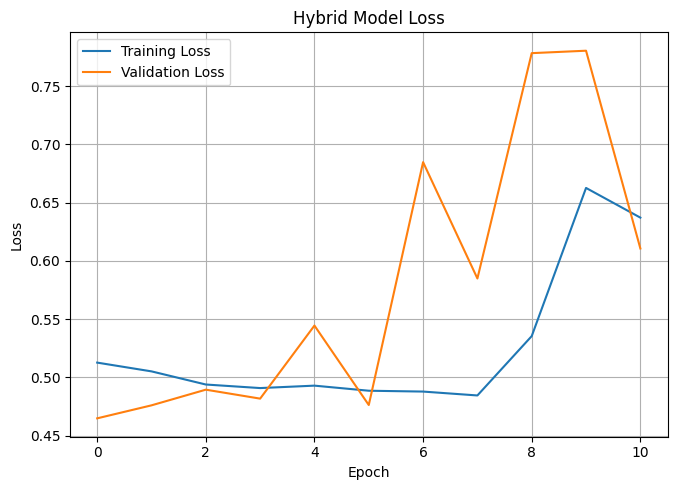

In [29]:
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(history_hybrid.history['loss'], label='Training Loss')
plt.plot(history_hybrid.history['val_loss'], label='Validation Loss')
plt.title('Hybrid Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

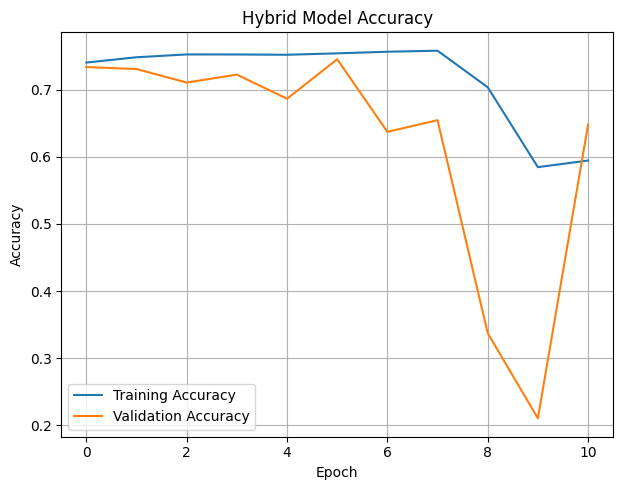

In [30]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(history_hybrid.history['accuracy'], label='Training Accuracy')
plt.plot(history_hybrid.history['val_accuracy'], label='Validation Accuracy')
plt.title('Hybrid Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 3. Transformer Model

In [31]:
# Import necessary libraries

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tqdm import tqdm
import datetime
import pickle
import math
import os

In [32]:
# Configuration
ask_file_name = '/kaggle/input/gbpusd/GBPUSD_15 Mins_Ask_2023.11.17_2025.03.31.csv'
bid_file_name = '/kaggle/input/gbpusd/GBPUSD_15 Mins_Bid_2023.11.17_2025.03.31.csv'

base_dir = '.'

ask_file = os.path.join(base_dir, ask_file_name)
bid_file = os.path.join(base_dir, bid_file_name)

time_column_name = 'Time (EET)'
time_format = None
take_profit_pips = 10
take_profit_level = take_profit_pips / 10000
forward_window_hours = 4
timeframe_minutes = 15
sliding_window_size = 50
train_test_split_ratio = 0.1
validation_split_ratio = 0.2
epochs = 50
batch_size = 32
patience = 10
learning_rate_transformer = 1e-4

# Transformer specific HPs
embed_dim = 64
num_heads = 4
ff_dim = 64
num_transformer_blocks = 2
transformer_dropout = 0.1
mlp_dropout = 0.1
mlp_units = [ff_dim // 2]

# Model/History File Names
transformer_model_file = 'best_GBPUSD_Transformer_model.keras'
transformer_history_file = 'gbpusd_transformer_training_history.pkl'

np.random.seed(19)
tf.random.set_seed(19)

print("Transformer Model")
print(f"  Ask file: {ask_file}")
print(f"  Bid file: {bid_file}")
print(f"  Time Column: {time_column_name}")

Transformer Model
  Ask file: /kaggle/input/gbpusd/GBPUSD_15 Mins_Ask_2023.11.17_2025.03.31.csv
  Bid file: /kaggle/input/gbpusd/GBPUSD_15 Mins_Bid_2023.11.17_2025.03.31.csv
  Time Column: Time (EET)


# 1. Load and Merge Data into single DataFrame

In [ ]:
# Check if the files exist before trying to read them
if not os.path.exists(ask_file):
    print(f"Error: The ask file '{ask_file}' was not found.")
    exit()

if not os.path.exists(bid_file):
    print(f"Error: The bid file '{bid_file}' was not found.")
    exit()

# Load the data with encoding and separator
df_ask = pd.read_csv(
    ask_file,
    sep=',',  # Comma separator
    parse_dates=[time_column_name],
    date_format=time_format,
    encoding='utf-8-sig'  # Specify encoding
)
df_bid = pd.read_csv(
    bid_file,
    sep=',',  # Comma separator
    parse_dates=[time_column_name],
    date_format=time_format,
    encoding='utf-8-sig'
)

# Clean column names function
def clean_columns(df):
    df.columns = df.columns.str.replace(r'[\u00A0\s]+', ' ', regex=True).str.strip()
    return df

# Clean columns for both dataframes
df_ask = clean_columns(df_ask)
df_bid = clean_columns(df_bid)

# Verify time column exists in both dataframes
if time_column_name not in df_ask.columns or time_column_name not in df_bid.columns:
    print(f"Error: Time column '{time_column_name}' missing after cleaning.")
    print("Ask columns:", df_ask.columns.tolist())
    print("Bid columns:", df_bid.columns.tolist())
    exit()

# Rename the time column in both dataframes before merging
df_bid.rename(columns={time_column_name: 'Local_Time'}, inplace=True)
df_ask.rename(columns={time_column_name: 'Local_Time'}, inplace=True)

# Merge on the renamed time column
data = pd.merge(df_bid, df_ask, on='Local_Time', how='inner', suffixes=('_Bid', '_Ask'))

# Print top 5 records of the merged data
print(data.head(5))


           Local_Time  Open_Bid  High_Bid  Low_Bid  Close_Bid  Volume_Bid  \
0 2023-11-17 00:00:00   1.24115   1.24167  1.24075    1.24150      210.74   
1 2023-11-17 00:15:00   1.24150   1.24150  1.24095    1.24121      682.60   
2 2023-11-17 00:30:00   1.24122   1.24141  1.24106    1.24114     1430.04   
3 2023-11-17 00:45:00   1.24115   1.24158  1.24112    1.24144     1917.39   
4 2023-11-17 01:00:00   1.24145   1.24151  1.24119    1.24150      379.44   

   Open_Ask  High_Ask  Low_Ask  Close_Ask  Volume_Ask  
0   1.24184   1.24229  1.24165    1.24165      167.11  
1   1.24175   1.24195  1.24126    1.24139      241.20  
2   1.24143   1.24165  1.24139    1.24149      390.15  
3   1.24151   1.24194  1.24148    1.24182      637.20  
4   1.24183   1.24184  1.24146    1.24163      306.91  


# 2. Feature Engineering and Data Transformation

In [ ]:
# Ensure 'Local_Time' is converted to datetime and handle invalid values
data['Local_Time'] = pd.to_datetime(data['Local_Time'], errors='coerce')
data = data.dropna(subset=['Local_Time']).copy()

# Ensure timezone localization and conversion
if data['Local_Time'].dt.tz is None:
    data['Timestamp_UTC'] = data['Local_Time'].dt.tz_localize('Europe/London', ambiguous='infer').dt.tz_convert('UTC')
else:
    data['Timestamp_UTC'] = data['Local_Time'].dt.tz_convert('UTC')

# Set the timestamp as index
data.set_index('Timestamp_UTC', inplace=True)
data.sort_index(inplace=True)

# Drop the 'Local_Time' column as it's no longer needed
data.drop(['Local_Time'], axis=1, inplace=True)

# Calculate deltas for the features
data["Open_Delta"] = data["Open_Ask"] - data["Open_Bid"]
data["High_Delta"] = data["High_Ask"] - data["High_Bid"]
data["Low_Delta"] = data["Low_Ask"] - data["Low_Bid"]
data["Close_Delta"] = data["Close_Ask"] - data["Close_Bid"]
data["Volume_Delta"] = data["Volume_Ask"] - data["Volume_Bid"]
data["Volume_Delta_abs"] = data["Volume_Delta"].abs()

# Time-related features
data['Time_Diff'] = data.index.to_series().diff().fillna(pd.Timedelta(seconds=0))
expected_interval = pd.Timedelta(minutes=timeframe_minutes)
data['Gap_Indicator'] = (data['Time_Diff'] > (expected_interval + pd.Timedelta(seconds=60))).astype(int)
data['New_Day'] = (data.index.normalize().diff() > pd.Timedelta(days=0)).astype(int)

# Placeholder columns for future use
data['Y_Low_Ask'] = data['Low_Ask']
data['Y_High_Bid'] = data['High_Bid']

# Drop temporary columns
data.drop(['Time_Diff', 'Gap_Indicator'], axis=1, inplace=True)

# Print final shape of the data
print(f"Feature engineering complete")
print(f"Shape of the Data:", data.shape)


Feature engineering complete
Shape of the Data: (33964, 19)


# 3. Target Variable Creation Define the target variable for the analysis.

In [ ]:
# Calculate periods per hour based on the timeframe
periods_per_hour = 60 // timeframe_minutes
forward_window_periods = forward_window_hours * periods_per_hour

# Create the rolling window indexer for forward window period
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=forward_window_periods)

# Create future values for 'Low' and 'High' prices using rolling window
data['Y_Low_Ask_Future'] = data['Y_Low_Ask'].rolling(indexer, min_periods=1).min()
data['Y_High_Bid_Future'] = data['Y_High_Bid'].rolling(indexer, min_periods=1).max()

# Calculate take profit hits based on future values
buy_tp_hit = (data["Y_High_Bid_Future"] - data["Close_Ask"]) >= take_profit_level
sell_tp_hit = (data["Close_Bid"] - data["Y_Low_Ask_Future"]) >= take_profit_level

# Create target variable 'Trend_Flat' based on take profit hits
data['Trend_Flat'] = ((buy_tp_hit) | (sell_tp_hit)).astype(int)

# Drop rows where future values are missing
data.dropna(subset=['Y_Low_Ask_Future', 'Y_High_Bid_Future'], inplace=True)

# Drop original and future values columns that are no longer needed
data.drop(['Y_Low_Ask', 'Y_High_Bid', 'Y_Low_Ask_Future', 'Y_High_Bid_Future'], axis=1, inplace=True)

# Print class distribution of the target variable 'Trend_Flat'
print("Class distribution:")
print(data['Trend_Flat'].value_counts(normalize=True))


Class distribution:
Trend_Flat
1    0.781386
0    0.218614
Name: proportion, dtype: float64


# 4. Data Normalization Ensuring that data is scaled and transformed to a common format for analysis.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize error flag
normalization_failed = False

# Check if the target column exists in the data
if 'Trend_Flat' in data.columns:
    target_column = 'Trend_Flat'
    y = data[target_column]
    X = data.drop(target_column, axis=1)

    # Check if there are missing values in X
    if X.isnull().any().any():
        print("Warning: Missing values detected in features. Handling missing values before normalization.")
        X = X.fillna(X.mean())  # Replace missing values with the mean of the column (or use other strategies)

    # Normalize the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

    # Get number of features
    num_features = X.shape[1]  # Number of columns (features) in X
    print(f"Number of features: {num_features}")

    # Indicate that normalization is complete
    print("Normalization complete.")
    print(X_scaled_df.head())

else:
    normalization_failed = True
    print(f"Normalization failed: Target column '{target_column}' not found in data.")

# Handle the case when normalization fails
if normalization_failed:
    exit()


Number of features: 17
Normalization complete.
                           Open_Bid  High_Bid   Low_Bid  Close_Bid  \
Timestamp_UTC                                                        
2023-11-17 00:00:00+00:00  0.233391  0.228833  0.232908   0.236106   
2023-11-17 00:15:00+00:00  0.236030  0.227545  0.234419   0.233919   
2023-11-17 00:30:00+00:00  0.233919  0.226863  0.235250   0.233391   
2023-11-17 00:45:00+00:00  0.233391  0.228151  0.235703   0.235653   
2023-11-17 01:00:00+00:00  0.235653  0.227621  0.236232   0.236106   

                           Volume_Bid  Open_Ask  High_Ask   Low_Ask  \
Timestamp_UTC                                                         
2023-11-17 00:00:00+00:00    0.008005  0.238045  0.232997  0.239063   
2023-11-17 00:15:00+00:00    0.025927  0.237366  0.230419  0.236116   
2023-11-17 00:30:00+00:00    0.054318  0.234952  0.228145  0.237099   
2023-11-17 00:45:00+00:00    0.072829  0.235556  0.230343  0.237779   
2023-11-17 01:00:00+00:00    0.01441

# 5. Data Preparation for Transformer Models

In [ ]:
# Initialize error flag
sequence_preparation_failed = False

# Convert X and y to numpy arrays
X_np = X_scaled_df.to_numpy()
y_np = y.to_numpy().reshape(-1, 1)

# Number of samples and sequences
num_samples = X_np.shape[0]
num_sequences = num_samples - sliding_window_size + 1

# Check if there are enough samples to create sequences
if num_sequences <= 0:
    print(f"Error: Not enough data ({num_samples} samples) to create sequences of length {sliding_window_size}.")
    sequence_preparation_failed = True
else:
    # Initialize sequences arrays
    X_sequences = np.zeros((num_sequences, sliding_window_size, num_features), dtype=np.float32)
    y_sequences = np.zeros((num_sequences, 1), dtype=np.float32)

    # Prepare sequences
    for i in range(num_sequences):
        X_sequences[i] = X_np[i: i + sliding_window_size]
        y_sequences[i] = y_np[i + sliding_window_size - 1]

    print(f"X_sequences shape: {X_sequences.shape}, y_sequences shape: {y_sequences.shape}")

# Exit if sequence preparation failed
if sequence_preparation_failed:
    exit()


100%|██████████| 33915/33915 [00:00<00:00, 193553.50it/s]

X_sequences shape: (33915, 50, 17), y_sequences shape: (33915, 1)


# 6. Train/Test Split for Transformer Models

In [ ]:
# Ensure data is valid before splitting
if len(X_sequences) == 0 or len(y_sequences) == 0:
    print("Error: Empty sequences.")
    exit()
else:
    # Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_sequences, y_sequences,
        test_size=train_test_split_ratio,
        shuffle=False,  # Critical for time-series data to maintain order
        stratify=None
    )

    # Check if splits are valid
    if len(X_train) == 0 or len(y_train) == 0:
        print("Error: Training data is empty after split.")
        exit()
    else:
        # Print shapes of the splits
        print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
        print(f"  X_test: {X_test.shape}, y_test: {y_test.shape}")


  X_train: (30523, 50, 17), y_train: (30523, 1)
  X_test: (3392, 50, 17), y_test: (3392, 1)


# 7. Handle Class Imbalance through techniques such as oversampling, undersampling, and using appropriate evaluation metrics.

In [ ]:
# Check if y_train is defined
if 'y_train' not in locals():
    print("Error: y_train not defined.")
    exit()
else:
    y_train_flat = y_train.ravel()
    unique_classes = np.unique(y_train_flat)

    # Check if there are multiple unique classes
    if len(unique_classes) > 1:
        class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_flat)
        class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
        print(f"Class weights: {class_weight_dict}")
    else:
        print("Class weights skipped.")
        class_weight_dict = None


Class weights: {0: 2.202872401847575, 1: 0.6468107649925832}


# 8. Transformer Model Building Overview and Implementation

In [40]:
from tensorflow.keras import layers

# Positional Encoding
def positional_encoding(length, depth):
    # Calculates fixed positional encoding.
    depth = depth / 2
    positions = np.arange(length)[:, np.newaxis]  # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth  # (1, depth)
    angle_rates = 1 / (10000**depths)  # (1, depth)
    angle_rads = positions * angle_rates  # (pos, depth)
    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    # Add batch dimension for broadcasting
    return tf.cast(pos_encoding, dtype=tf.float32)[tf.newaxis, ...]

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        # Dense layer to project input features to the embedding dimension
        self.feature_projection = layers.Dense(output_dim)
        self.position_encoding = positional_encoding(length=sequence_length, depth=output_dim)
        # Ensure output_dim is compatible with positional encoding depth
        if output_dim % 2 != 0:
             raise ValueError(f"Output dimension (embed_dim={output_dim}) "
                              "must be even for sin/cos positional encoding.")

    def call(self, x):
        length = tf.shape(x)[1] # Get sequence length from input tensor
        # Project features to embedding dimension
        x = self.feature_projection(x)
        # Add positional encoding (slice to match input length if necessary)
        x = x + self.position_encoding[:, :length, :]
        return x

    def get_config(self):
        # Required for saving/loading custom layers
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
            "output_dim": self.output_dim,
        })
        return config

# Transformer Block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        # Multi-Head Attention
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # Feed Forward Network
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        # Layer Normalization
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        # Dropout
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False): # Add training flag for dropout
        # Self-attention - Add & Norm
        attn_output = self.att(query=inputs, value=inputs, key=inputs) # Self-attention
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        # Feed Forward = Add & Norm
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

    def get_config(self):
        # Required for saving/loading custom layers
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
        })
        return config

# Build the Full Model
def build_transformer_model(sequence_length, num_features, embed_dim, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0.1, mlp_dropout=0.1):
    inputs = layers.Input(shape=(sequence_length, num_features))

    # 1. Positional Embedding
    embedding_layer = PositionalEmbedding(sequence_length, num_features, embed_dim)
    x = embedding_layer(inputs)

    # 2. Transformer Blocks
    for _ in range(num_transformer_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, rate=dropout)(x)

    # 3. Classification Head
    x = layers.GlobalAveragePooling1D()(x) # Pool sequence to fixed size vector
    x = layers.Dropout(mlp_dropout)(x)
    # MLP layers
    for units in mlp_units:
         x = layers.Dense(units, activation="relu")(x)
         x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x) # Final binary classification

    return keras.Model(inputs=inputs, outputs=outputs)

# Instantiate the model
transformer_model = build_transformer_model(
    sliding_window_size,
    num_features,
    embed_dim,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units=mlp_units,
    dropout=transformer_dropout,
    mlp_dropout=mlp_dropout
)

# Compile the model
transformer_model.compile(optimizer=AdamW(learning_rate=learning_rate_transformer),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])

transformer_model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 50, 17)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ positional_embedding                 │ (None, 50, 64)              │           1,152 │
│ (PositionalEmbedding)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 50, 64)              │          74,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_1                  │ (None, 50, 64)              │          74,944 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 153,153 (598.25 KB)

 Trainable params: 153,153 (598.25 KB)

 Non-trainable params: 0 (0.00 B)

# 9. Train Transformer Model

In [ ]:
# Callbacks
trans_early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience, verbose=1, restore_best_weights=True)
trans_model_checkpoint = ModelCheckpoint(transformer_model_file, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history_transformer = transformer_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split_ratio,
    shuffle=True,
    callbacks=[trans_early_stopping, trans_model_checkpoint],
    class_weight=class_weight_dict,
    verbose=1
)

# Save history
if 'history_transformer' in locals() and hasattr(history_transformer, 'history'):
    try:
        with open(transformer_history_file, 'wb') as file:
            pickle.dump(history_transformer.history, file)
        print("Transformer training history saved successfully.")
    except Exception as e:
        print(f"Could not save transformer training history. Error: {e}")
else:
    print("Error: 'history_transformer' or its 'history' attribute is not available.")


Epoch 1/50


I0000 00:00:1745237656.928938      94 service.cc:148] XLA service 0x2ee82c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745237656.929791      94 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 36/764 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4924 - loss: 0.7504 

I0000 00:00:1745237662.093881      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


764/764 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4121 - loss: 0.7215
Epoch 1: val_loss improved from inf to 0.72890, saving model to best_GBPUSD_Transformer_model.keras
764/764 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.4120 - loss: 0.7215 - val_accuracy: 0.1446 - val_loss: 0.7289
Epoch 2/50
754/764 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3130 - loss: 0.7132
Epoch 2: val_loss did not improve from 0.72890
764/764 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3132 - loss: 0.7132 - val_accuracy: 0.1446 - val_loss: 0.7309
Epoch 3/50
761/764 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2936 - loss: 0.7124
Epoch 3: val_loss did not improve from 0.72890
764/764 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2935 - loss: 0.7124 - val_accuracy: 0.1446 - val_loss: 0.7435
Epoch 4/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2619 - loss: 0.7124
Epoch 4: val_loss did not improve from 0.72890
764/764 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2620 - loss: 0.71

# 10. Evaluate Transformer Model using Attention Mechanism

In [ ]:
# Load best saved model
if 'transformer_model_file' in locals() and 'PositionalEmbedding' in locals() and 'TransformerBlock' in locals():
    if os.path.exists(transformer_model_file):
        final_best_transformer_model = keras.models.load_model(
            transformer_model_file,
            custom_objects={'PositionalEmbedding': PositionalEmbedding, 'TransformerBlock': TransformerBlock}
        )
        print(f"Loaded best transformer model from {transformer_model_file}.")
    else:
        print(f"Error: {transformer_model_file} does not exist.")
        final_best_transformer_model = transformer_model  # Fallback
else:
    print("Error: Required variables (transformer_model_file, PositionalEmbedding, TransformerBlock) are not defined.")
    final_best_transformer_model = transformer_model  # Fallback


# Evaluate
transformer_scores = final_best_transformer_model.evaluate(X_test, y_test, verbose=0) # Verbose 0 for cleaner output
print("\nTransformer Model Test Set Evaluation:")
print(f"  Loss: {transformer_scores[0]:.4f}")
print(f"  Accuracy: {transformer_scores[1]*100:.2f}%")

# Classification Report
transformer_predictions_prob = final_best_transformer_model.predict(X_test)
transformer_predictions_binary = np.round(transformer_predictions_prob)

print("\nClassification Report (Transformer Test Set):")
y_test_flat = y_test.ravel()
if len(np.unique(y_test_flat)) > 1:
     report_transformer = classification_report(y_test_flat, transformer_predictions_binary, digits=4, output_dict=False) # Get string report
     report_transformer_dict = classification_report(y_test_flat, transformer_predictions_binary, digits=4, output_dict=True) # Get dict for comparison script
     print(report_transformer)
     # Save the report dictionary for the comparison script
     try:
         with open('transformer_report_dict.pkl', 'wb') as f:
             pickle.dump(report_transformer_dict, f)

     except Exception as e:
         print(f"Could not save transformer report dict. Error: {e}")

else:
    print(f"Could not save transformer placeholder report dict. Error: {e}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'positional_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_block_1', howe

Loaded best transformer model from best_GBPUSD_Transformer_model.keras.

Transformer Model Test Set Evaluation:
  Loss: 0.5149
  Accuracy: 69.99%
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Classification Report (Transformer Test Set):
              precision    recall  f1-score   support

         0.0     0.3032    0.8530    0.4473       483
         1.0     0.9651    0.6745    0.7940      2909

    accuracy                         0.6999      3392
   macro avg     0.6341    0.7637    0.6207      3392
weighted avg     0.8708    0.6999    0.7446      3392



# 11. Visualize Transformer Training

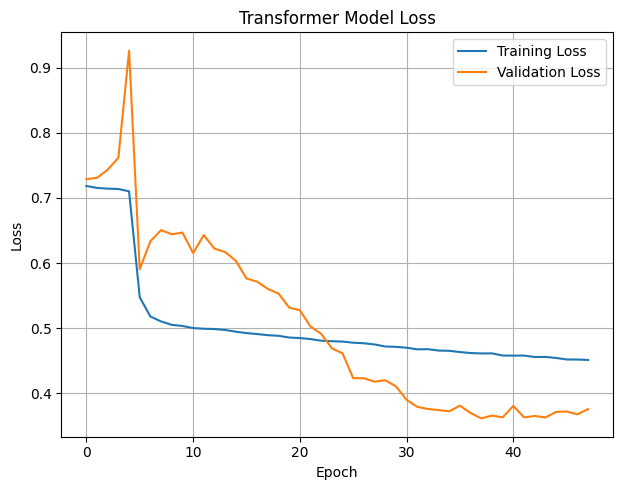

In [43]:

history_to_plot = history_transformer.history

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_to_plot['loss'], label='Training Loss')
plt.plot(history_to_plot['val_loss'], label='Validation Loss')
plt.title('Transformer Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

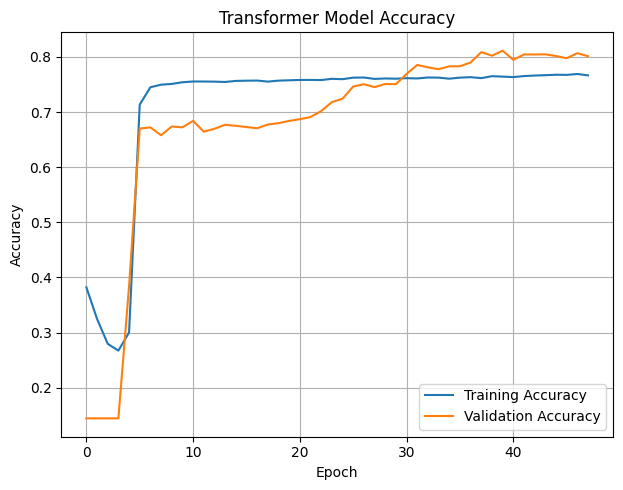

In [44]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(history_to_plot['accuracy'], label='Training Accuracy')
plt.plot(history_to_plot['val_accuracy'], label='Validation Accuracy')
plt.title('Transformer Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Results

In [77]:
# Imports + load test set
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve,
    confusion_matrix
)
import pickle
from tensorflow import keras

# Flatten for metrics
y_test_flat = y_test.ravel()


In [53]:
# Load models

# TrendFlat LSTM
model_lstm = keras.models.load_model('best_GBPUSD_TrendFlat_model.keras')
y_prob_lstm = model_lstm.predict(X_test)
y_pred_lstm = np.round(y_prob_lstm)

# Hybrid LSTM+GRU
model_hybrid = keras.models.load_model('best_GBPUSD_Hybrid_model.keras')
y_prob_hybrid = model_hybrid.predict(X_test)
y_pred_hybrid = np.round(y_prob_hybrid)

# Transformer — now that PositionalEmbedding & TransformerBlock are in memory
model_trans = keras.models.load_model(
    'best_GBPUSD_Transformer_model.keras',
    custom_objects={
        'PositionalEmbedding': PositionalEmbedding,
        'TransformerBlock': TransformerBlock
    }
)
y_prob_trans = model_trans.predict(X_test)
y_pred_trans = np.round(y_prob_trans)


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'positional_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_block_1', howe

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [55]:
# models_data = {}
# for name, y_pred, y_prob in [
#     ('Tuned LSTM', y_pred_lstm, y_prob_lstm),
#     ('Hybrid LSTM+GRU', y_pred_hybrid, y_prob_hybrid),
#     ('Transformer',   y_pred_trans,   y_prob_trans)
# ]:
#     acc = accuracy_score(y_test_flat, y_pred.ravel())
#     prec = precision_score(y_test_flat, y_pred.ravel(), average='weighted', zero_division=0)
#     rec = recall_score(y_test_flat, y_pred.ravel(), average='weighted', zero_division=0)
#     f1  = f1_score(y_test_flat, y_pred.ravel(), average='weighted', zero_division=0)
#     models_data[name] = {
#         'Accuracy': acc,
#         'Precision (Weighted)': prec,
#         'Recall (Weighted)': rec,
#         'F1‑Score (Weighted)':   f1
#     }
#     print(f"Done metrics for {name}")


Done metrics for Tuned LSTM
Done metrics for Hybrid LSTM+GRU
Done metrics for Transformer


# Tabular display of all metrics

In [56]:
import pandas as pd
metrics_df = pd.DataFrame(models_data).T
metrics_df.index.name = 'Model'
metrics_df


,Accuracy,Precision (Weighted),Recall (Weighted),F1‑Score (Weighted)
Model,,,,
Tuned LSTM,0.857606,0.735488,0.857606,0.791867
Hybrid LSTM+GRU,0.807488,0.745635,0.807488,0.773525
Transformer,0.699882,0.870824,0.699882,0.744647


# Grouped bar chart of metrics

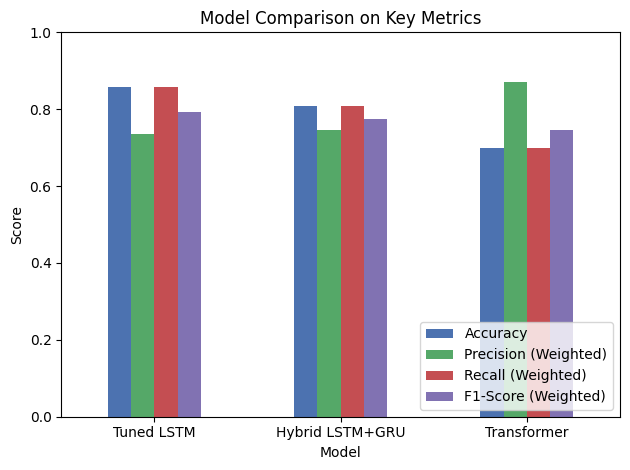

In [57]:
metrics_df.plot(kind='bar', rot=0)
plt.title("Model Comparison on Key Metrics")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# ROC curves

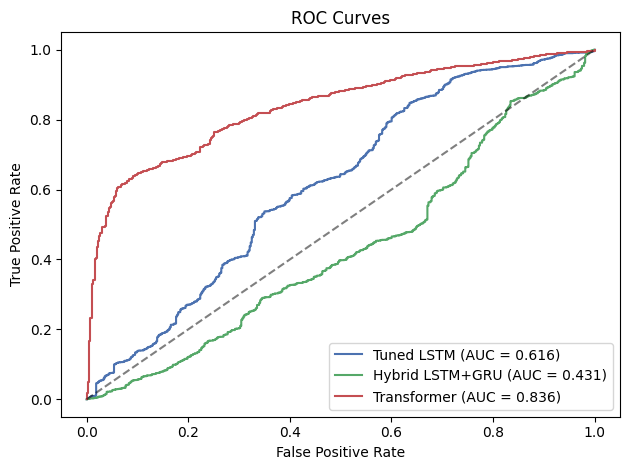

In [58]:
plt.figure()
for name, y_prob in [
    ('Tuned LSTM', y_prob_lstm),
    ('Hybrid LSTM+GRU', y_prob_hybrid),
    ('Transformer',   y_prob_trans)
]:
    fpr, tpr, _ = roc_curve(y_test_flat, y_prob.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


# Precision–Recall curves 

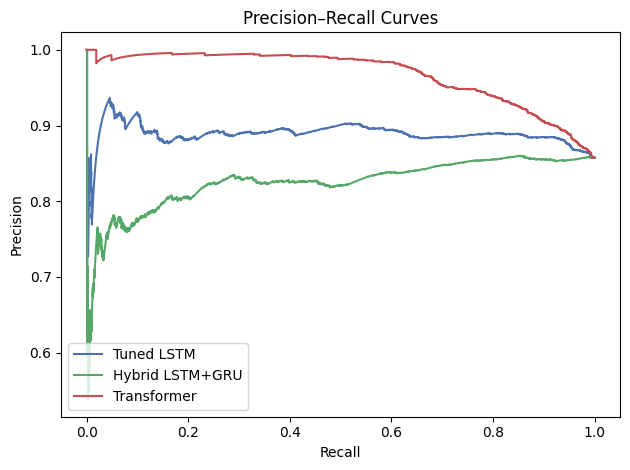

In [59]:
plt.figure()
for name, y_prob in [
    ('Tuned LSTM', y_prob_lstm),
    ('Hybrid LSTM+GRU', y_prob_hybrid),
    ('Transformer',   y_prob_trans)
]:
    precision, recall, _ = precision_recall_curve(y_test_flat, y_prob.ravel())
    plt.plot(recall, precision, label=name)
plt.title("Precision–Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


# Confusion matrices

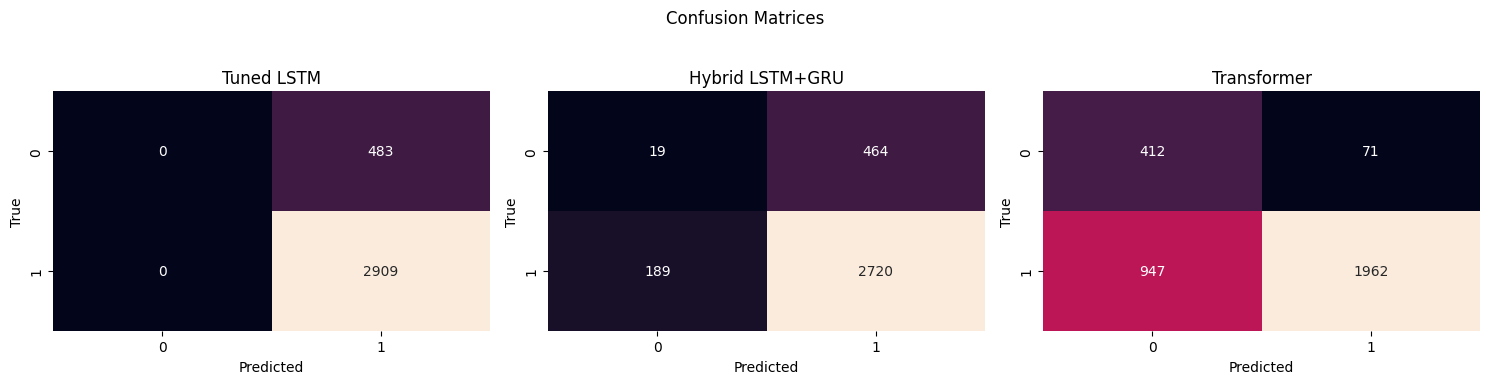

In [60]:
fig, axes = plt.subplots(1,3,figsize=(15,4))
for ax, (name, y_pred) in zip(axes, [
    ('Tuned LSTM', y_pred_lstm),
    ('Hybrid LSTM+GRU', y_pred_hybrid),
    ('Transformer',   y_pred_trans)
]):
    cm = confusion_matrix(y_test_flat, y_pred.ravel())
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cbar=False)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.suptitle("Confusion Matrices")
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()


# Plot Training & Validation Loss/Accuracy for All Models

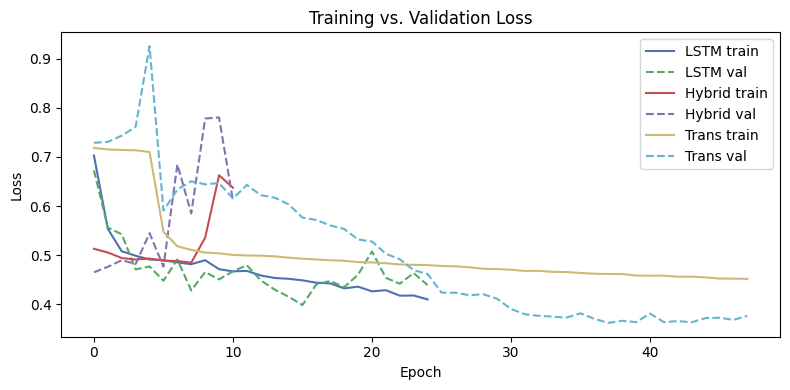

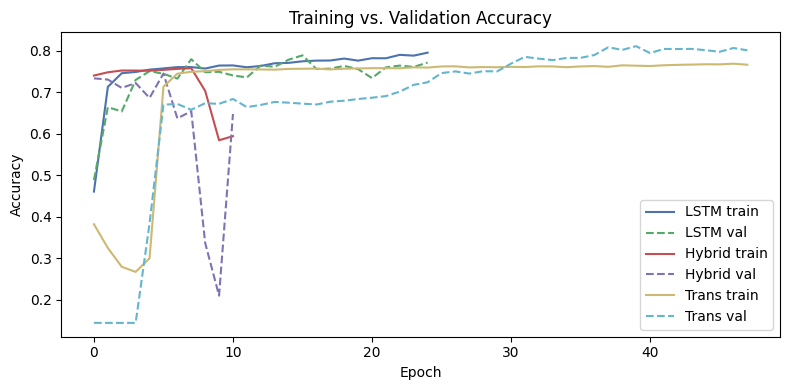

In [64]:
import pickle
import matplotlib.pyplot as plt

# Load histories as pkl file
hist_lstm      = pickle.load(open('/kaggle/working/gbpusd_training_history.pkl', 'rb'))
hist_hybrid    = pickle.load(open('/kaggle/working/gbpusd_hybrid_training_history.pkl', 'rb'))
hist_trans     = pickle.load(open('/kaggle/working/gbpusd_transformer_training_history.pkl','rb'))

# Plot Loss
plt.figure(figsize=(8,4))
for name, hist in [('LSTM', hist_lstm), ('Hybrid', hist_hybrid), ('Trans', hist_trans)]:
    plt.plot(hist['loss'],        label=f'{name} train')
    plt.plot(hist['val_loss'],    label=f'{name} val', linestyle='--')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.tight_layout(); plt.show()

# Plot Accuracy
plt.figure(figsize=(8,4))
for name, hist in [('LSTM', hist_lstm), ('Hybrid', hist_hybrid), ('Trans', hist_trans)]:
    plt.plot(hist['accuracy'],     label=f'{name} train')
    plt.plot(hist['val_accuracy'], label=f'{name} val', linestyle='--')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.tight_layout(); plt.show()


# Calibration Curves

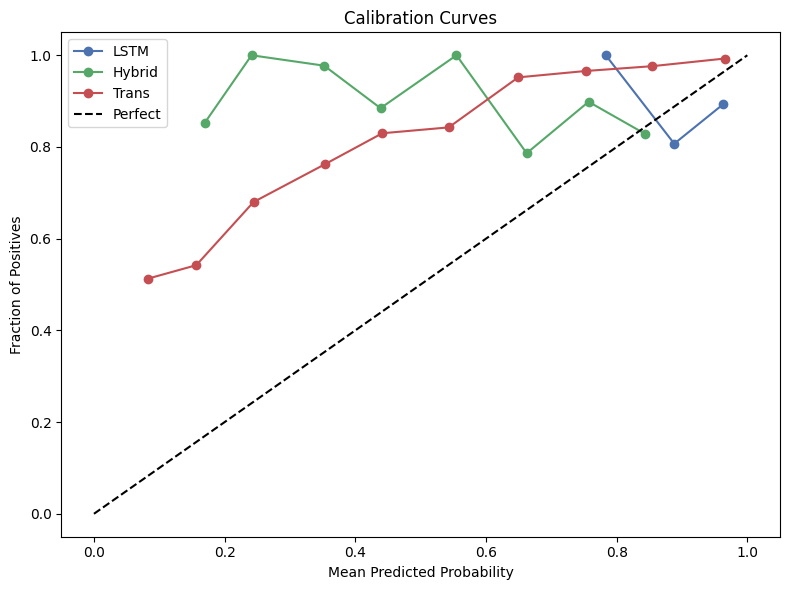

In [65]:
from sklearn.calibration import calibration_curve
plt.figure(figsize=(8,6))
for name, y_prob in [
    ('LSTM',    y_prob_lstm),
    ('Hybrid',  y_prob_hybrid),
    ('Trans',   y_prob_trans)
]:
    prob_true, prob_pred = calibration_curve(y_test_flat, y_prob.ravel(), n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)
plt.plot([0,1],[0,1],'k--', label='Perfect')
plt.title('Calibration Curves')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend(); plt.tight_layout(); plt.show()


# Predicted‑Probability Distributions by Class

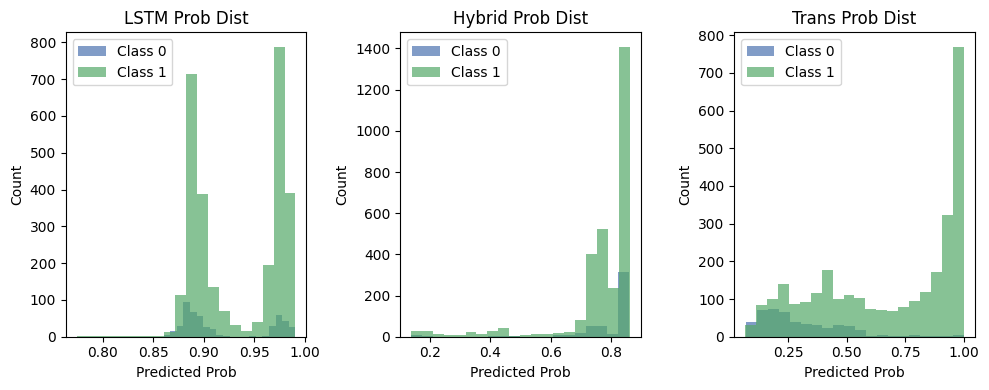

In [66]:
plt.figure(figsize=(10,4))
for i, (name, y_prob) in enumerate([
    ('LSTM',   y_prob_lstm),
    ('Hybrid', y_prob_hybrid),
    ('Trans',  y_prob_trans)
]):
    plt.subplot(1,3,i+1)
    plt.hist(y_prob[y_test_flat==0].ravel(), bins=20, alpha=0.7, label='Class 0')
    plt.hist(y_prob[y_test_flat==1].ravel(), bins=20, alpha=0.7, label='Class 1')
    plt.title(f'{name} Prob Dist')
    plt.xlabel('Predicted Prob'); plt.ylabel('Count')
    plt.legend()
plt.tight_layout(); plt.show()


# Optimal Threshold vs. F1‑Score for One Model (e.g., Transformer)

Best Transformer threshold = 0.11, F1 = 0.924


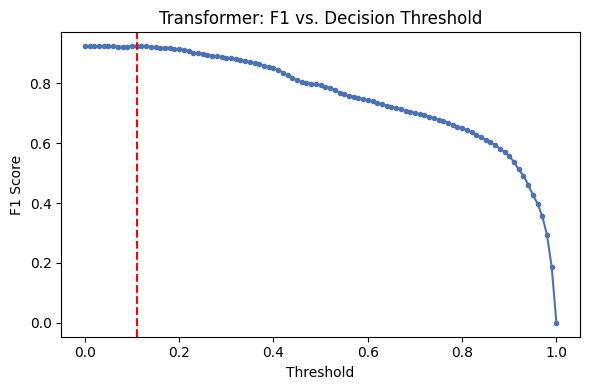

In [67]:
from sklearn.metrics import f1_score

probs = y_prob_trans.ravel()
thresholds = np.linspace(0.0, 1.0, 101)
f1s = [f1_score(y_test_flat, (probs >= t).astype(int)) for t in thresholds]

best_idx = np.argmax(f1s)
print(f'Best Transformer threshold = {thresholds[best_idx]:.2f}, F1 = {f1s[best_idx]:.3f}')

plt.figure(figsize=(6,4))
plt.plot(thresholds, f1s, marker='.')
plt.axvline(thresholds[best_idx], color='red', linestyle='--')
plt.title('Transformer: F1 vs. Decision Threshold')
plt.xlabel('Threshold'); plt.ylabel('F1 Score')
plt.tight_layout(); plt.show()


# PCA of Test‑Set Features, True vs. Predicted

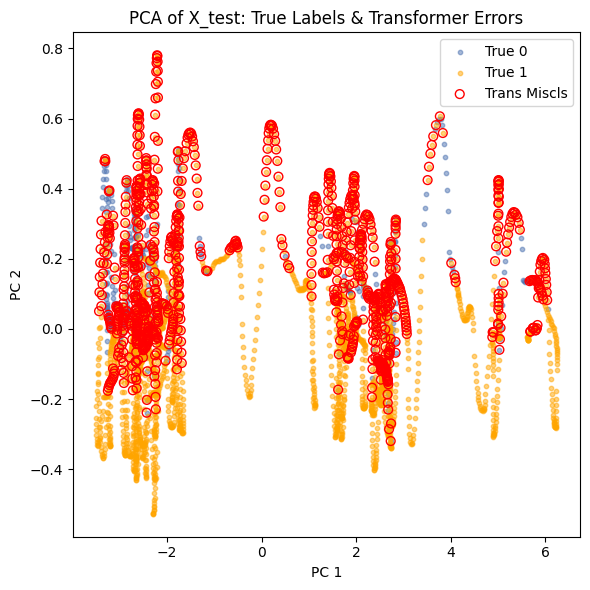

In [68]:
from sklearn.decomposition import PCA

X_flat = X_test.reshape(X_test.shape[0], -1)
pca = PCA(n_components=2)
pc = pca.fit_transform(X_flat)

plt.figure(figsize=(6,6))
plt.scatter(pc[y_test_flat==0,0], pc[y_test_flat==0,1], s=10, alpha=0.5, label='True 0')
plt.scatter(pc[y_test_flat==1,0], pc[y_test_flat==1,1], s=10, alpha=0.5, label='True 1', color='orange')

mis = (y_pred_trans.ravel() != y_test_flat)
plt.scatter(pc[mis,0], pc[mis,1], facecolors='none', edgecolors='red', s=40, label='Trans Miscls')

plt.title('PCA of X_test: True Labels & Transformer Errors')
plt.xlabel('PC 1'); plt.ylabel('PC 2')
plt.legend(); plt.tight_layout(); plt.show()


# Precision & Recall vs Threshold for All Models

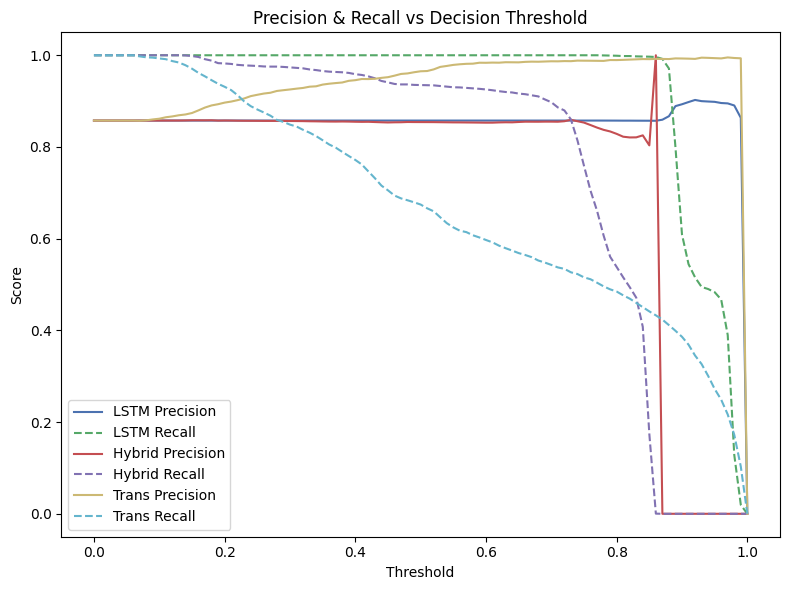

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

thresholds = np.linspace(0.0, 1.0, 101)
plt.figure(figsize=(8,6))
for name, probs in [
    ('LSTM',   y_prob_lstm),
    ('Hybrid', y_prob_hybrid),
    ('Trans',  y_prob_trans)
]:
    precisions = []
    recalls    = []
    for t in thresholds:
        preds = (probs.ravel() >= t).astype(int)
        precisions.append(precision_score(y_test_flat, preds, zero_division=0))
        recalls.append(recall_score(y_test_flat, preds, zero_division=0))
    plt.plot(thresholds, precisions, linestyle='-', label=f'{name} Precision')
    plt.plot(thresholds, recalls,    linestyle='--', label=f'{name} Recall')
plt.title('Precision & Recall vs Decision Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# Cumulative Gain (Lift) Chart

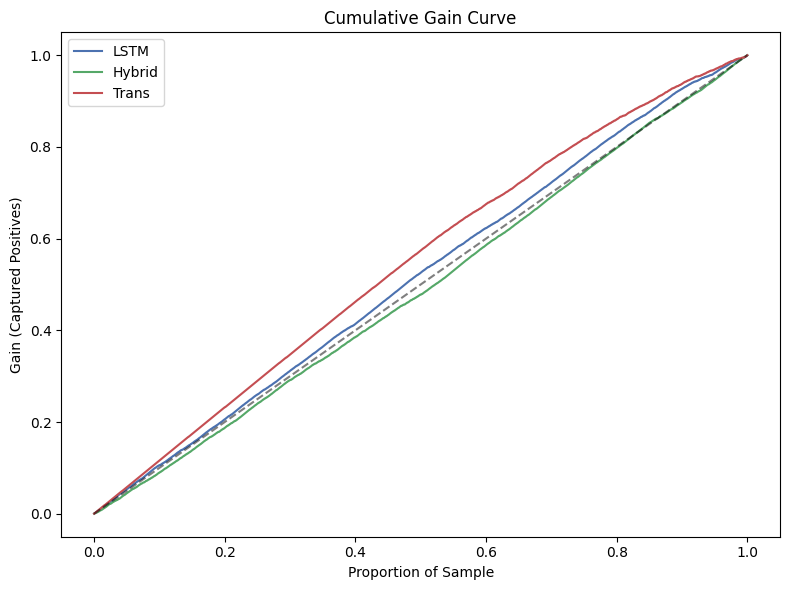

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for name, probs in [
    ('LSTM',   y_prob_lstm),
    ('Hybrid', y_prob_hybrid),
    ('Trans',  y_prob_trans)
]:
    df_gain = pd.DataFrame({'y': y_test_flat, 'prob': probs.ravel()})
    df_gain = df_gain.sort_values('prob', ascending=False).reset_index(drop=True)
    df_gain['cum_pos'] = df_gain['y'].cumsum()
    df_gain['gain']    = df_gain['cum_pos'] / df_gain['y'].sum()
    df_gain['pct_samples'] = (df_gain.index + 1) / len(df_gain)
    plt.plot(df_gain['pct_samples'], df_gain['gain'], label=name)
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.title('Cumulative Gain Curve')
plt.xlabel('Proportion of Sample')
plt.ylabel('Gain (Captured Positives)')
plt.legend()
plt.tight_layout()
plt.show()


# t-SNE of Test Features, Colored by True vs Predicted (Transformer)

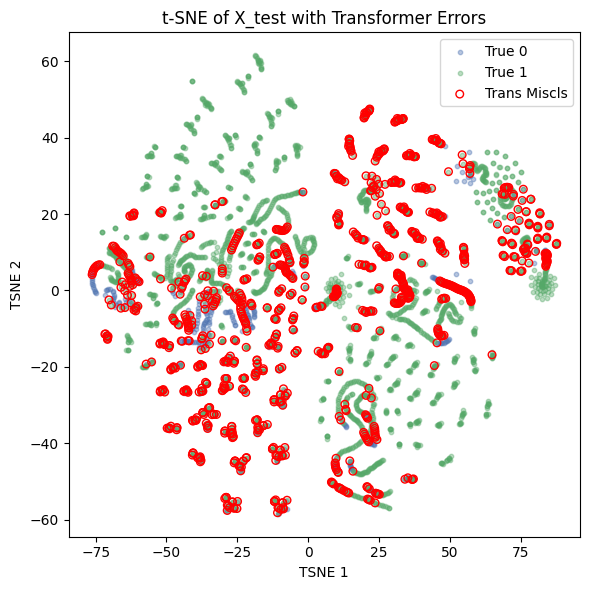

In [71]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Flatten data 
X_flat = X_test.reshap
e(X_test.shape[0], -1)
tsne = TSNE(n_components=2, random_state=42, init='pca')
X_emb = tsne.fit_transform(X_flat)

plt.figure(figsize=(6,6))
# True labels
plt.scatter(X_emb[y_test_flat==0,0], X_emb[y_test_flat==0,1],
            s=10, alpha=0.4, label='True 0')
plt.scatter(X_emb[y_test_flat==1,0], X_emb[y_test_flat==1,1],
            s=10, alpha=0.4, label='True 1')
# Misclassified by Transformer
mis = (y_pred_trans.ravel() != y_test_flat)
plt.scatter(X_emb[mis,0], X_emb[mis,1],
            facecolors='none', edgecolors='red', s=30,
            label='Trans Miscls')
plt.title('t-SNE of X_test with Transformer Errors')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# Classification Report Heatmaps

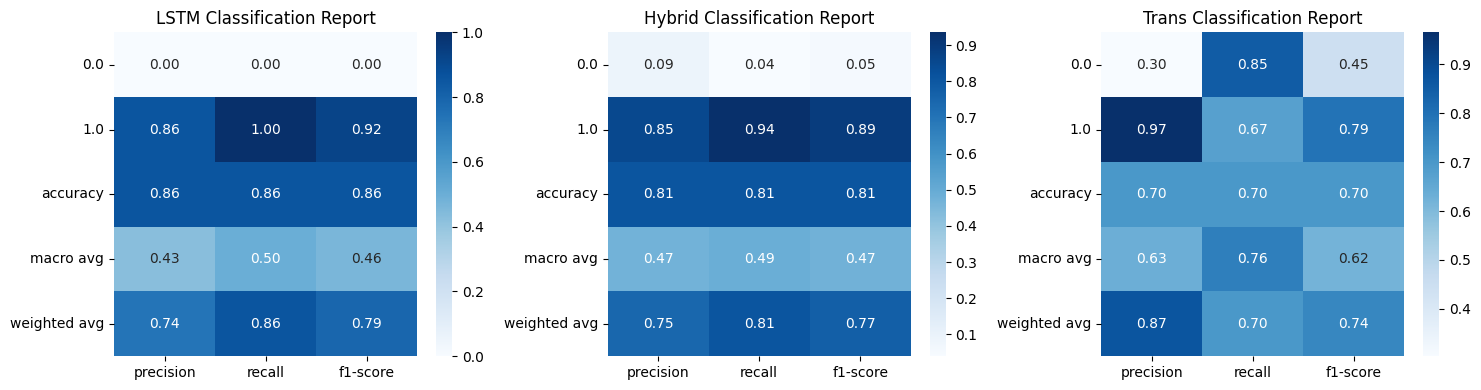

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

reports = {}
for name, preds in [
    ('LSTM',   y_pred_lstm),
    ('Hybrid', y_pred_hybrid),
    ('Trans',  y_pred_trans)
]:
    rpt = classification_report(y_test_flat, preds.ravel(), output_dict=True, zero_division=0)
    rpt_df = pd.DataFrame(rpt).iloc[:-1, :].T
    reports[name] = rpt_df

fig, axes = plt.subplots(1, 3, figsize=(15,4))
for ax, (name, rpt_df) in zip(axes, reports.items()):
    sns.heatmap(rpt_df, annot=True, fmt='.2f', cmap='Blues', ax=ax)
    ax.set_title(f'{name} Classification Report')
plt.tight_layout()
plt.show()


# Brier Score Comparison Bar Chart

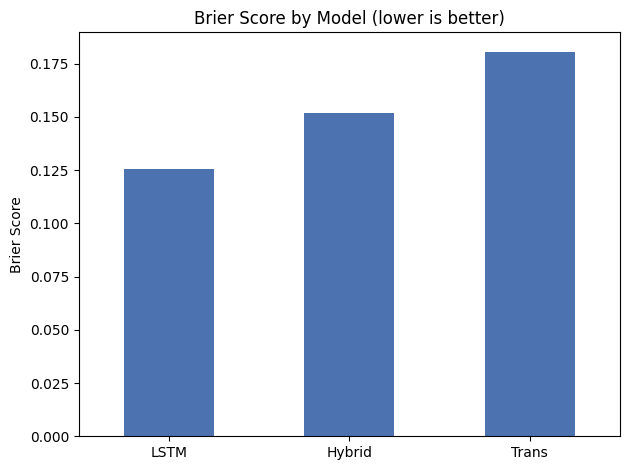

In [75]:
from sklearn.metrics import brier_score_loss

brier_scores = {
    name: brier_score_loss(y_test_flat, probs.ravel())
    for name, probs in [
        ('LSTM',   y_prob_lstm),
        ('Hybrid', y_prob_hybrid),
        ('Trans',  y_prob_trans)
    ]
}
pd.Series(brier_scores).plot(kind='bar', rot=0)
plt.title('Brier Score by Model (lower is better)')
plt.ylabel('Brier Score')
plt.tight_layout()
plt.show()
